# Práctica 1: Regresión Lineal

### Jorge Villarrubia Elvira y Juan Carlos Villanueva Quirós

### Parte 1: Regresión lineal con una variable
En esta primera parte aplicamos el método de regresión lineal sobre los datos del fichero ex1data1.csv. Aplicamos el método de descenso de gradiente para encontrar los parámetros theta que definen la recta que mejor se ajusta a los datos de entrenamiento.

In [1]:
#Importamos todas las librerias y funciones necesarias
%matplotlib inline

import numpy as np
from numpy.linalg import inv
from pandas.io.parsers import read_csv
from matplotlib import pyplot as plt
from IPython.display import clear_output
from mpl_toolkits.mplot3d import Axes3D

In [147]:
def carga_csv(file_name):
    """carga el fichero csv especificado y lo
    devuelve en un array de numpy
    """
    valores = read_csv(file_name, header=None).to_numpy()
    # suponemos que siempre trabajaremos con float
    return valores.astype(float)

def fun_coste(y_predicted, y_truth) :
    """
    Args:
        y_predicted: vector de predicciones
        y_truth: vector con los valores reales
    
    Dados el vector de predicciones y el vector de valores reales, calcula y devuelve el coste asociado
    """
    return np.sum((y_predicted - y_truth)**2) / (2*len(y_predicted))

def fun_h(theta_0, theta_1, X) :
    """
    Args:
        theta_0: Primer parametro que define a la recta, este será el valor de la recta en x = 0.
        theta_1: Segundo parametro que define a la recta. Representa la pendiente de la recta.
        X: Vector de valores que queremos predecir
    
    Dados los parametros de la recta y el vector X de valores a predecir, evalua la recta en los puntos X.
    """
    return theta_0 + theta_1 * X

def descenso_gradiente(X, Y, learning_rate, init_theta_0, init_theta_1, iteraciones, debug = False):
    """
    Args:
        X: Vector de datos a predecir
        Y: Vector con la predicciones correcta de los datos
        learning_rate: Parametro que controla cuánto nos movemos en cada iteracion del descenso
        init_theta_0: Parametro inicial de la recta
        init_theta_1: Parametro inicial de la recta
        iteraciones: Numero de iteraciones que vamos a ejecutar el descenso
        debug: Si debug = True, imprimimos el coste y la grafica de la recta obtenida hasta el momento.
    
    Realiza el algoritmo de descenso del gradiente.      
    """
    
    theta_0 = init_theta_0
    theta_1 = init_theta_1
    m = len(X)
    
    for i in range(iteraciones):
        #Actualizamos los thetas con respecto a las formulas de las derivadas parciales de la funcion de coste.
        #Importante: hay que actualizar simultáneamente ambas componentes de theta, luego creamos una variable auxiliar
        #            para no perder el theta_0 al calcular el theta_1.
        aux = theta_0
        theta_0 = theta_0 - learning_rate * np.sum(fun_h(aux, theta_1, X) - Y) / m 
        theta_1 = theta_1 - learning_rate * np.sum((fun_h(aux, theta_1, X) - Y) * X) / m
        
        if debug and i % (iteraciones / 25) == 0 : #Si queremos debuggear, printeamos 25 veces el coste y la grafica
            clear_output(wait = True) #Para que borre lo printeado de la iteracion anterior
            print("Coste: ", fun_coste(fun_h(theta_0, theta_1, X), Y))

            grid = np.linspace(5, 22, 500)
            fun = fun_h(theta_0, theta_1, grid)
            
            plt.scatter(X, Y, marker = 'x', color = 'red')
            plt.plot(grid, fun)
            plt.show()
        
    return theta_0, theta_1

Coste:  4.4849107176798215


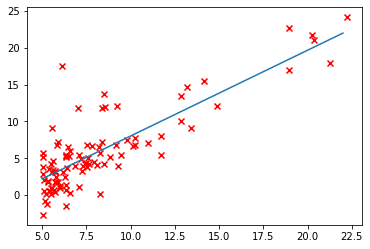

In [148]:
#Cargamos los datos
aux = carga_csv('ex1data1.csv')
X = aux[:, 0]
Y = aux[:, 1]

#Ejecutamos el algoritmo de descenso de gradiente para calcular theta_0 y theta_1 optimos
theta_0, theta_1 = descenso_gradiente(X, Y, learning_rate = 0.01, init_theta_0 = 0, init_theta_1 = 0,
                                      iteraciones = 1500, debug = True)

#### Visualización de la función de coste
A continuación, generamos gráficas para visualizar mejor nuestra función de coste.

In [149]:
def make_data(t0_range, t1_range, X, Y):
    """
    Args:
        t0_range: rango de la superficie en theta_0
        t1_range: rango de la superficie en theta_1
        X: Vector de valores
        Y: Vector de predicciones correctas
    
    Genera la matriz de coste para cada punto de la malla sobre la que dibujamos la superficie
    """
    
    step = 0.1
    theta_0 = np.arange(t0_range[0], t0_range[1], step)
    theta_1 = np.arange(t1_range[0], t1_range[1], step)
    theta_0, theta_1 = np.meshgrid(theta_0, theta_1) #Creamos la malla
    
    coste = np.empty_like(theta_0)
    for x, y in np.ndindex(theta_0.shape):
        coste[x, y] = fun_coste(fun_h(theta_0[x, y], theta_1[x, y], X), Y) #Coste para cierto punto (x, y)
        
    return theta_0, theta_1, coste

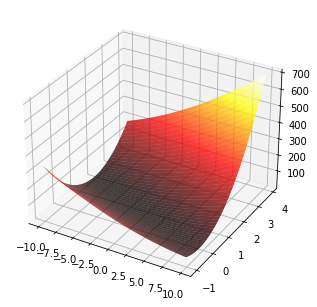

In [150]:
X_axis, Y_axis, Z_axis = make_data(t0_range = [-10, 10], t1_range = [-1, 4], X = X, Y = Y)

fig = plt.figure()
ax = Axes3D(fig)
ax.plot_surface(X_axis, Y_axis, Z_axis, rstride = 1, cstride = 1, cmap = 'hot') #Dibujamos la superficie

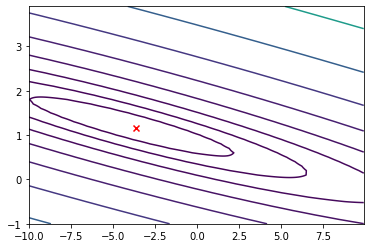

In [151]:
plt.scatter(theta_0, theta_1, marker = 'x', color = 'red')
plt.contour(X_axis, Y_axis, Z_axis, np.logspace(-2, 3, 20)) #Dibujamos la superficie como mapa de contornos
plt.show()

### Parte 2: Regresión lineal con una variable
En esta segunda parte aplicamos el método de regresión lineal sobre los datos del fichero ex2data1.csv. Esta vez, tendremos dos atributes en los datos de entrada (tamaño de cada casa en pies cuadrados y número de habitaciones).

Para realizar el descenso de gradiente, primero normalizaremos los datos de entrada, alcanzando así una mayor eficiencia. 

Por otro lado, realizaremos una versión vectorizada del descenso de gradiente, que funciona independientemente del número de atributos.

In [152]:
def fun_h(theta, X) :
    """Version vectorizada de la fun_h anterior.
    Args:
        theta_1: Parametros que definen a la recta
        X: Vector de valores que queremos predecir
    
    Dados los parametros de la recta y el vector X de valores a predecir, evalua la recta en los puntos X.
    """
    return np.matmul(X, theta)

def normalize_data(X):
    """
    Args:
        X: Datos de entrada
        
    Dados unos datos de entrada, los normaliza haciendo (datos - media) / desviacion_estandar.
    Ademas, devuelve las medias y desviaciones estandar obtenidas
    """
    
    media = np.mean(X, axis = 0)
    desviacion = np.std(X, axis = 0)
    
    return (X - media) / desviacion, media, desviacion 

def multi_descenso_gradiente(X, Y, learning_rate, init_theta, iteraciones, debug = False):
    """
    Args:
        X: Vector de datos a predecir
        Y: Vector con la predicciones correcta de los datos
        learning_rate: Parametro que controla cuánto nos movemos en cada iteracion del descenso
        init_theta: Parametros iniciales de la recta
        iteraciones: Numero de iteraciones que vamos a ejecutar el descenso
        debug: Si debug = True, imprimimos el coste obtenido hasta el momento.
    
    Realiza el algoritmo de descenso del gradiente en su version vectorizada.
    """
    
    theta = init_theta
    m = np.shape(X)[0]
    
    for i in range(iteraciones):
        #Actualizamos theta con respecto a las formulas de las derivadas parciales de la funcion de coste.
        #Importante: hay que actualizar simultáneamente ambas componentes de theta, luego creamos una variable auxiliar
        #            para almacenar el vector theta anterior
        aux = theta
        theta = theta - learning_rate * np.matmul(X.T, (fun_h(aux, X) - Y)) / m #Vectorizado!

        if debug and i % (iteraciones / 25) == 0 : #Si queremos debuggear, printeamos 25 veces el coste y la grafica
            print("Coste: ", fun_coste(fun_h(theta, X), Y))
            
    return theta

In [153]:
#Cargamos nuestros datos
datos = carga_csv("ex1data2.csv")
X = datos[:, :-1]
Y = datos[:, -1]

m = np.shape(X)[0]
n = np.shape(X)[1]

#Normalizamos los datos
X_normalized, media, desviacion = normalize_data(X)

#Anadimos la columna de 1's, para que funcione la version vectorizada
X_normalized = np.hstack([np.ones([m, 1]), X_normalized])
X = np.hstack([np.ones([m, 1]), X])

#Ejecutamos el algoritmo de descenso de gradiente vectorizado
theta = multi_descenso_gradiente(X_normalized, Y, learning_rate = 0.01, init_theta = np.array([0, 0, 0]),
                                 iteraciones = 1500, debug = False)
#Imprimimos por pantalla el vector theta optimo calculado
print(theta)

[340412.56301439 109370.05670466  -6500.61509507]


A continuación, resolvemos de nuevo el problema utilizando el método de la ecuación normal que obtiene en un sólo paso el valor óptimo de theta.

In [154]:
theta_normal = np.matmul(np.matmul(inv(np.matmul(X.T, X)), X.T), Y)
print(theta_normal)

[89597.9095428    139.21067402 -8738.01911233]


Ahora, demostramos que los cálculos son correctos comprobando que el modelo obtenido con descenso de gradiente hace las mismas predicciones que el que resulta la ecuación normal, aplicándolo a una casa de superficie 1650 pies cuadrados y 3 habitaciones.

In [155]:
#Normalizamos los datos correspondientemente
pred1 = fun_h(theta, [1, (1650 - media[0])/desviacion[0], (3-media[1])/desviacion[1]]) 

#Para la ecuacion normal, no hace falta normalizar los datos
pred2 = fun_h(theta_normal, [1, 1650, 3])

#Imprimimos por pantalla ambas predicciones y el error obtenido
print(pred1, pred2, "\nError: ", pred2 - pred1)

293098.4666757651 293081.46433489653 
Error:  -17.002340868581086
